# 29. 사이킷런을 활용한 추천 시스템 입문 👍👍

## 추천 시스템이란 ❓
- 사용자(user)에게 관련된 아이템(item)을 추천해 주는 것

## 💟 추천 logic 
1. 범주형, 이산적인 데이터를 숫자 벡터로 변환합니다.
2. 이 숫자 벡터의 유사도를 계산하여 유사도가 가까운 (혹은 높은) 제품을 추천해 줍니다.

## 💟 코사인 유사도(Cosine Similarity)
코사인 유사도는 두 벡터의 방향이 이루는 각에 코사인을 취해 구합니다.
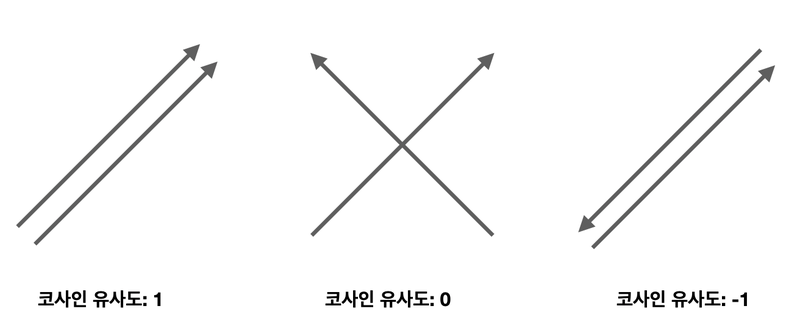
- 두 벡터의 방향이 완전히 동일한 경우는 1, 90°의 각을 이루면 0, 반대 방향, 즉 각이 180°이면 -1
- 코사인 유사도는 -1 ~ 1사이의 값이고, 1에 가까울 수록 유사도가 높다
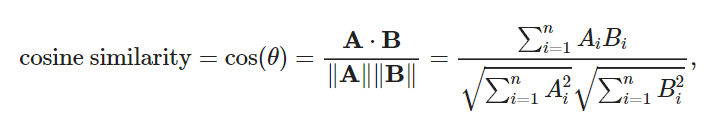

### 1. 숫자 벡터가 만들어졌다고 가정

In [1]:
import numpy as np

t1 = np.array([1, 1, 1])
t2 = np.array([2, 0, 1])

### 2. 코사인 유사도 구하는 함수

In [2]:
from numpy import dot
from numpy.linalg import norm
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [3]:
cos_sim(t1, t2)

0.7745966692414834

## 💟 사이킷런 활용
코사인 모듈을 임포트 해주면 쉽게 사용 가능

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

- 해당 모듈은 입력값으로 2차원 배열을 받기 때문에, 2차원 배열로 정의해주어야 함

In [5]:
t1 = np.array([[1, 1, 1]])
t2 = np.array([[2, 0, 1]])
cosine_similarity(t1,t2)

array([[0.77459667]])

### ⏳ 기타 다른 유사도 계산법
코사인 유사도 이외에도 유클리드 거리, 자카드 유사도, 피어슨 상관계수 등의 다른 방법으로 유사도를 계산할 수 있습니다.

## 💟 추천시스템의 종류

### 1. 협업 필터링 방식(Collaborative Filtering)
- 사용자 기반
- 아이템 기반
- 잠재요인 협업 필터링 (latent factor collaborative filtering) → 행렬 인수분해(matrix factorization)

### 2. 콘텐츠 기반 필터링 방식(Content Based Filtering)
- 콘텐츠 기반은 순수하게 콘텐츠의 내용만을 비교해서 추천하는 방식
- 영화를 고르는 기준: 장르, 배우, 감독 등의 정보를 '특성(Feature)'라고 한다
- 이 특성이 '콘텐츠'가 비슷하다고 말할 수 있는 요인이 된다

### 3. Deep Learning 적용 or Hybrid 방식
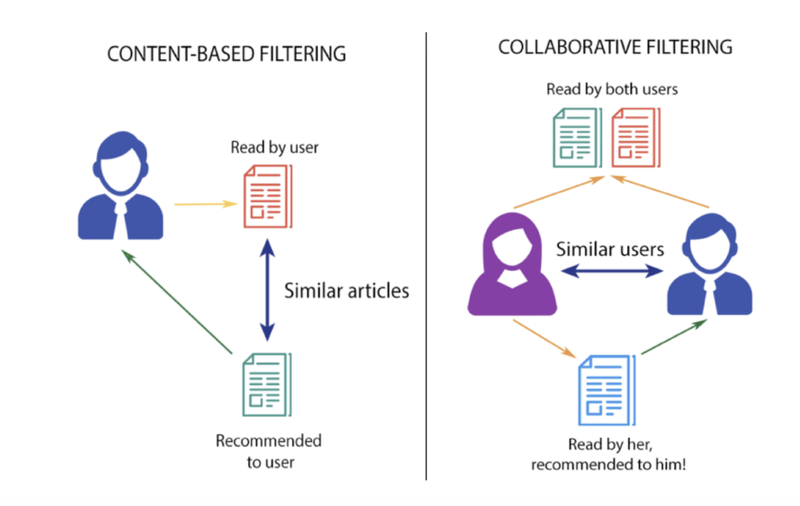

## 💟 콘텐츠 기반 필터링 실습
>해당 예제는 CODE HEROKU의 'Building a Movie Recemmendation Engine in Python using Scikit-Learn' 을 바탕으로 제작되었다.

### 1) 필요한 모듈을 import합니다.

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print('⏩⏩')

⏩⏩


### 2) Load 데이터
예제 데이터는 movie_dataset을 사용하도록 하겠습니다. 다음 데이터를 다운로드 받은 뒤 ~/aiffel/movie_recommendation 디렉토리 내에 저장합니다.

movie_dataset.csv
```
wget https://aiffelstaticprd.blob.core.windows.net/media/documents/movie_dataset.csv
mv movie_dataset.csv  ~/aiffel/movie_recommendation
```

In [7]:
import os
csv_path = os.getenv('HOME')+'/aiffel/movie_recommendation/movie_dataset.csv'
df = pd.read_csv(csv_path)
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


### 3) 특성 선택

In [8]:
df.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

#### -  다음과 같은 특성만 고려하여 영화의 유사도를 계산하여 추천하기

In [9]:
features = ['keywords','cast','genres','director']
features

['keywords', 'cast', 'genres', 'director']

In [10]:
def combine_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']

combine_features(df[:5])

0    culture clash future space war space colony so...
1    ocean drug abuse exotic island east india trad...
2    spy based on novel secret agent sequel mi6 Dan...
3    dc comics crime fighter terrorist secret ident...
4    based on novel mars medallion space travel pri...
dtype: object

In [11]:
for feature in features:
    df[feature] = df[feature].fillna('')

df["combined_features"] = df.apply(combine_features,axis=1)
df["combined_features"]

0       culture clash future space war space colony so...
1       ocean drug abuse exotic island east india trad...
2       spy based on novel secret agent sequel mi6 Dan...
3       dc comics crime fighter terrorist secret ident...
4       based on novel mars medallion space travel pri...
                              ...                        
4798    united states\u2013mexico barrier legs arms pa...
4799     Edward Burns Kerry Bish\u00e9 Marsha Dietlein...
4800    date love at first sight narration investigati...
4801     Daniel Henney Eliza Coupe Bill Paxton Alan Ru...
4802    obsession camcorder crush dream girl Drew Barr...
Name: combined_features, Length: 4803, dtype: object

- 여기서는 간단하게 보기 위해 해당 특성을 텍스트 데이터로 보고, 보고자 하는 특성으로 이루어진 텍스트 데이터를 새로운 칼럼으로 생성하였습니다.

### 4) 칼럼을 벡터화한 후, 코사인 유사도 계산
#### - 장르, 배우명, 감독명의 텍스트 데이터를 범주형 데이터로 보기 때문에 단순하게 등장횟수를 세어 숫자 벡터로 만들기  
 사이킷런의 `CountVectorizer()` 사용

In [12]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["combined_features"])
print(type(count_matrix))
print(count_matrix.shape)
print(count_matrix)

<class 'scipy.sparse.csr.csr_matrix'>
(4803, 14845)
  (0, 3115)	1
  (0, 2616)	1
  (0, 4886)	1
  (0, 12386)	2
  (0, 14235)	1
  (0, 2755)	1
  (0, 12299)	1
  (0, 11517)	1
  (0, 14561)	1
  (0, 14820)	1
  (0, 11490)	1
  (0, 12134)	1
  (0, 14291)	1
  (0, 12567)	1
  (0, 7496)	1
  (0, 8831)	1
  (0, 11217)	1
  (0, 86)	1
  (0, 144)	1
  (0, 4435)	1
  (0, 11745)	1
  (0, 4566)	1
  (0, 6542)	1
  (0, 2061)	1
  (1, 86)	1
  :	:
  (4801, 10069)	1
  (4801, 5844)	1
  (4801, 252)	1
  (4801, 4098)	1
  (4801, 14796)	1
  (4801, 11361)	1
  (4801, 2978)	1
  (4801, 12036)	1
  (4801, 6138)	1
  (4802, 9659)	1
  (4802, 3812)	1
  (4802, 1788)	2
  (4802, 4210)	1
  (4802, 5181)	1
  (4802, 2912)	1
  (4802, 3821)	1
  (4802, 1069)	1
  (4802, 11185)	1
  (4802, 3681)	1
  (4802, 5399)	1
  (4802, 3894)	1
  (4802, 2056)	1
  (4802, 3093)	1
  (4802, 4502)	1
  (4802, 5900)	2


- count_matrix는 type: CSR(Compressed Sparse Row) Matrix
> ## ⏳ CSR Matrix
Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보로만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조  
>
> 예를 들어, (0, 3115) 1라고 되어 있는 것은 1번째 row는 3116번째 단어가 1번 출현한다는 뜻입니다. 이 데이터셋에는 총 14845개의 단어가 존재하는데, 이 단어들을 범주형으로 보고 그 단어의 출현 빈도만을 표시한 Matrix가 매우 Sparse하기 때문에 공간을 절약할 수 있는 형태로 표현한 것입니다.  


### 💟 4803개의 영화들이 모두 Vectorized 됨.
#### - 영화들끼리의 코사인 유사도를 표현하는 4803X4803 의 cosine_similarity matrix를 구해보기

In [13]:
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)
print(cosine_sim.shape)

[[1.         0.10540926 0.12038585 ... 0.         0.         0.        ]
 [0.10540926 1.         0.0761387  ... 0.03651484 0.         0.        ]
 [0.12038585 0.0761387  1.         ... 0.         0.11145564 0.        ]
 ...
 [0.         0.03651484 0.         ... 1.         0.         0.04264014]
 [0.         0.         0.11145564 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.04264014 0.         1.        ]]
(4803, 4803)


### 5) 추천
코사인 유사도로 계산된 가장 비슷한 영화를 3편을 선별하여 추천해 보겠습니다.

In [14]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_user_likes = "Avatar"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))

sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]

i=0
print(movie_user_likes+"와 비슷한 영화 3편은 "+"\n")
for item in sorted_similar_movies:
    print(get_title_from_index(item[0]))
    i=i+1
    if i == 3:
        break

Avatar와 비슷한 영화 3편은 

Guardians of the Galaxy
Aliens
Star Wars: Clone Wars: Volume 1


- 아바타(Avatar)와 유사한 영화 3편은 가디언즈 오브 갤럭시, 에어리언, 스타워즈이다.

## 협업 필터링(Collaborative Filtering)이란 ❓
과거의 사용자 행동 양식(User Behavior) 데이터를 기반으로 추천하는 방식입니다. 

###  Interaction matrix, 즉 평점행렬로 변환
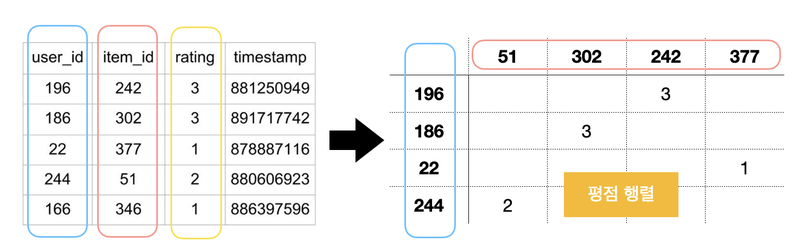
- 이러한 행렬을 실제 데이터로 만든다면 굉장히 희소(sparse)한 행렬이 만들어집니다.


## 💟 협업 필터링의 종류
**사용자 기반**과 **아이템 기반** 그리고 **잠재요인(latent factor)** 방식

### 1. 사용자 기반
- 평점행렬로 변환한 후, 평점행렬의 유사도를 계산하여 추천하는 방식
- 동일한 제품에 대해 평점을 매긴 데이터를 분석하여 추천을 하는 방식
> `당신과 비슷한 고객들이 다음 상품을 구매했습니다. `  
여기 사용자와 아이템 간의 평점행렬이 있습니다. User4가 item1을 구매하였습니다.   
그리고 User4와 가장 유사한 User2는 item1 ~ 4까지 다음과 같이 평점을 매겼습니다.  
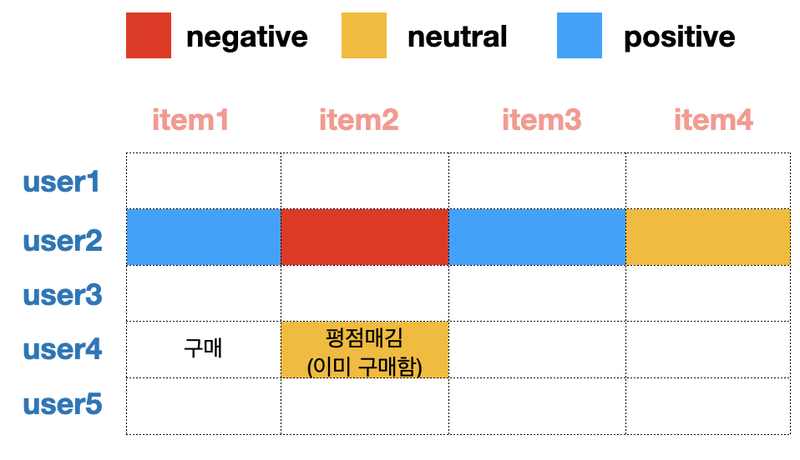
> ### Q. 그러면 어떤 제품을 추천해 주면 좋을까요?
User2가 선호한 제품인 item3을 User4에게 추천해 주는 방식

### 2. 아이템 기반
-  아이템 간의 유사도를 측정하여 해당 아이템을 추천하는 방식
- 사용자 기반보다는 아이템 기반 방식이 정확도가 더 높다
> `이 상품을 선택한 다른 고객들은 다음 상품을 구매했습니다.`  
User2가 선호하는 아이템이 있습니다. 그 아이템은 item1이네요.    
item1을 좋아한 사람은 user4입니다. 그 user4에게 user2가 좋아한 상품인 item3을 추천해 줍니다.
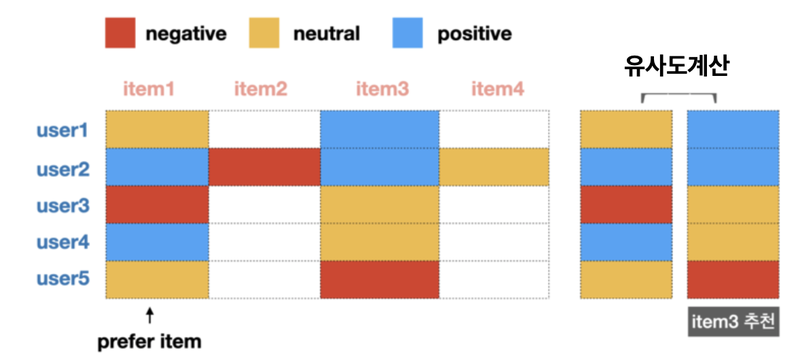


## 정리
사용자 기반: 당신과 비슷한 고객들이 다음 상품을 구매했습니다.

아이템 기반: 이 상품을 선택한 다른 고객들은 다음 상품을 구매했습니다.

--- 
## 행렬 인수분해 ❓
행렬 인수분해는 인수분해와 비슷하다고 볼 수 있습니다. 30을 인수분해하면 30 = 6X5 = 3X10 = 1X30 이런 식으로 곱하기로 나타낼 수 있겠죠? 행렬도 이렇게 곱으로 분해 할 수 있으며, 분해 행렬을 사용하면 원하는 답을 더 쉽게 찾을 수 있습니다. (나중에 이야기 하겠지만, 추천 알고리즘에서 파라미터 수가 줄어 듭니다!)

## 💟 행렬 인수분해 기법  
### 1. SVD(Singular Vector Decomposition)
- **특잇값 분해** : M X N 형태의 행렬 A을 다음과 같은 형태로 분해하여 나타내는 것
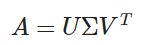
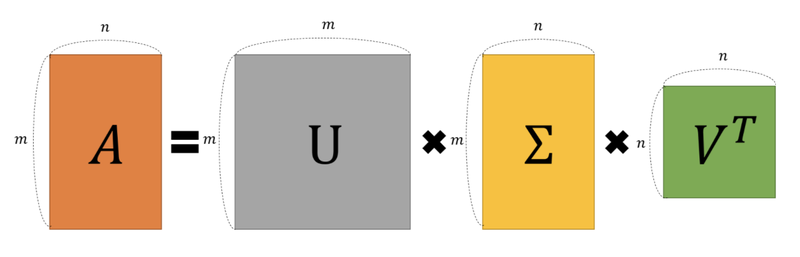
[특이값 분해(SVD)](https://angeloyeo.github.io/2019/08/01/SVD.html)
[[선형대수학 #4] 특이값 분해(Singular Value Decomposition, SVD)의 활용](https://youtu.be/epoHE2rex0g)


**- SVD는 "정보 복원"을 위해 사용한다.**
> 특이값 분해는 분해되는 과정보다는 분해된 행렬을 다시 조합하는 과정에서 그 응용력이 빛을 발한다. 기존의 U,Σ,VTU,Σ,VT로 분해되어 있던 AA행렬을 특이값 p개만을 이용해 A’라는 행렬로 ‘부분 복원’ 시킨 할 수 있다. 위에서 말했던 것 특이값의 크기에 따라 A의 정보량이 결정되기 때문에 값이 큰 몇 개의 특이값들을 가지고도 충분히 유용한 정보를 유지할 수 있다. (중략) 최대한 중요한 정보들만 부분 복원해서 사용하면 사진의 용량은 줄어들지만 여전히 사진이 보여주고자 하는 내용은 살릴 수 있을 것이다.

### 💟 SVD 실습
`numpy.linalg.svd` 사용 : https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html


####  - numpy.linalg의 svd 모듈을 import한 후, 4 X 4형태의 행렬 A를 SVD해보기

In [15]:
import numpy as np
from numpy.linalg import svd

In [16]:
np.random.seed(30)
A = np.random.randint(0, 100, size=(4, 4))
A

array([[37, 37, 45, 45],
       [12, 23,  2, 53],
       [17, 46,  3, 41],
       [ 7, 65, 49, 45]])

In [17]:
svd(A)

(array([[-0.54937068, -0.2803037 , -0.76767503, -0.1740596 ],
        [-0.3581157 ,  0.69569442, -0.13554741,  0.60777407],
        [-0.41727183,  0.47142296,  0.28991733, -0.72082768],
        [-0.6291496 , -0.46389601,  0.55520257,  0.28411509]]),
 array([142.88131188,  39.87683209,  28.97701433,  14.97002405]),
 array([[-0.25280963, -0.62046326, -0.4025583 , -0.6237463 ],
        [ 0.06881225, -0.07117038, -0.8159854 ,  0.56953268],
        [-0.73215039,  0.61782756, -0.23266002, -0.16767299],
        [-0.62873522, -0.47775436,  0.34348792,  0.50838848]]))

결과값으로 행렬 U와 행렬 Σ, 행렬 V의 전치행렬이 생성됩니다. 
#### - 이 값들을 unpacking해서 각각 변수명에 할당한 후, 각 행렬들을 확인해보기

In [18]:
U, Sigma, VT = svd(A)

print('U matrix: {}\n'.format(U.shape),U)
print('Sigma: {}\n'.format(Sigma.shape),Sigma)
print('V Transpose matrix: {}\n'.format(VT.shape),VT)

U matrix: (4, 4)
 [[-0.54937068 -0.2803037  -0.76767503 -0.1740596 ]
 [-0.3581157   0.69569442 -0.13554741  0.60777407]
 [-0.41727183  0.47142296  0.28991733 -0.72082768]
 [-0.6291496  -0.46389601  0.55520257  0.28411509]]
Sigma: (4,)
 [142.88131188  39.87683209  28.97701433  14.97002405]
V Transpose matrix: (4, 4)
 [[-0.25280963 -0.62046326 -0.4025583  -0.6237463 ]
 [ 0.06881225 -0.07117038 -0.8159854   0.56953268]
 [-0.73215039  0.61782756 -0.23266002 -0.16767299]
 [-0.62873522 -0.47775436  0.34348792  0.50838848]]


분해가 잘 되었음을 확인할 수 있다. 
#### - 다시 복원해 보기
- 복원을 위해서는 U, Σ, VT를 내적합니다. 
- 한 가지 유의할 사항은 Σ는 1차원 이므로 `0을 포함한 대각 행렬로 변환`한 뒤 내적을 해주어야합니다.

In [19]:
Sigma_mat = np.diag(Sigma)

A_ = np.dot(np.dot(U, Sigma_mat), VT)
A_

array([[37., 37., 45., 45.],
       [12., 23.,  2., 53.],
       [17., 46.,  3., 41.],
       [ 7., 65., 49., 45.]])

복원된 A_와 원본 A가 같은지 확인해 보자.
## Truncated SVD ❓
- 잘린 SVD 
- LSA(Latent semantic analysis), 잠재 의미 분석
- Truncated SVD를 이용해 분해한 뒤 복원하면 SVD 처럼 완벽히 같은 행렬이 나오지 않습니다. 그 이유는 Truncated SVD는 차원을 축소한 다음 행렬을 분해하기 때문입니다.

#### 사이킷런에서는 TruncatedSVD 기능 함수로 제공
[sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)